In [2]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline
  
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib import colors
from visualization import Visualizer2D as vis
from gqcnn.grasping.grasp import Grasp2D
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

In [3]:
# the following cells will use the rai framework for robot control, simulation and motion planning
# https://github.com/MarcToussaint/rai
import sys
import os 
print(os.getcwd())
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../../ry/')
sys.path.append('../../')
sys.path.append('../')
import libry as ry
import time
import gc
import os
from collections import defaultdict
import utils

from webserver import sampleClient
import vision
import cv2

# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
os.environ["ROS_IP"] = "129.69.216.155"
"""
total ERROR = 0.00241405
total ERROR after radius correction = 0.00221046
*** total Pinv:
[0.00180045, 5.51994e-06, -0.569533, -0.0330757,
 -1.82321e-06, -0.00133149, 1.00136, 0.125005,
 5.08217e-05, -0.00117336, -0.439092, 1.55487]
*** camera intrinsics K:
[555.197, -8.21031, -334.467,
 0, -563.526, -271.392,
 0, 0, -1.02162]
*** camera world pos: [-0.0330757, 0.125005, 1.55487]
*** camera world rot: [0.935411, 0.35328, -0.0133783, 0.00451155]
"""
cam_world_pos= [-0.0330757, 0.125005, 1.55487]
cam_world_rot= [0.935411, 0.35328, -0.0133783, 0.00451155]
chestCamIntrinsics = {'fx': 555.197 , 
                       'fy':  -563.526, 
                       'cx': -334.467, 
                       'cy': -271.392, 'width': 640, 'height':480}
cam_rot = [0.935411, 0.35328, -0.0133783, 0.00451155]
K = np.array([
[555.197, -8.21031, -334.467],
 [0, -563.526, -271.392],
 [0, 0, -1.02162]
])
pinv_chest = np.array([[0.00180045, 5.51994e-06, -0.569533, -0.0330757],
  [-1.82321e-06, -0.00133149, 1.00136, 0.125005],
  [5.08217e-05, -0.00117336, -0.439092, 1.55487]])

/home/niklas/git/uni/robotics-course/practical/clean


/home/niklas/.local/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [4]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
gc.collect()
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../rai-robotModels/baxter/baxter_new.g')
cam = C.addObject(name="cam", parent="base_footprint", shape=ry.ST.sphere, size=[0.01], color=[0,1,0], pos=cam_world_pos, quat=cam_world_rot)
nodeName = "ralf"

q_home = C.getJointState()
q_zero = q_home.copy() * 0.
B = C.operate(nodeName)
B.sync(C)
C.makeObjectsConvex()
B.sendToReal(False)
cam = ry.Camera(nodeName, "/camera/rgb/image_rect_color", "/camera/depth/image_rect_raw", True)

In [132]:
def check_target(targetFrame):
    if not targetFrame in C.getFrameNames():
        frame = C.addObject(name=targetFrame, parent="base_footprint" ,shape=ry.ST.sphere, size=[.01], pos=[0,0,0], color=[0.,0.,1.])
    return C.frame(targetFrame)

def close_pj(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-2] = 0.04
    else:
        q[-2] = 0
    B.move([q], [1], True)
    
def close_suction(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-1] = 0.1
    else:
        q[-1] = 0
    B.move([q], [1], True)
    
def close_both(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-2] = 0.04
        q[-1] = 0.1
    else:
        q[-1] = 0
        q[-2] = 0
    B.move([q], [1], True)

def plan_path_pj(targetPos, angle, targetFrame, gripperFrame, steps, time):
    intermediatePos = [targetPos[0], targetPos[1], targetPos[2] + 0.1]
    intermediate = check_target("intermediate")
    target = check_target(targetFrame)
    angle = -angle
    axis = pinv_chest @ np.array([0, 0, 1, 1])
    r = R.from_quat([axis[0]*np.sin(-angle/2), axis[1]*np.sin(-angle/2), axis[2]*np.sin(-angle/2), np.cos(angle/2)])
    angle_z = (r.as_euler('zyx'))[0]
    rotM = utils.rotz(angle_z)
    print("anglez_befor:", angle)
    print("anglez:", angle_z)
    quat = utils.rotm2quat(rotM)
    B.sync(C)
    target.setPosition(targetPos)
    target.setQuaternion(quat)
    intermediate.setPosition(intermediatePos)
    pp = C.komo_path(1, steps, time, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames=[gripperFrame, targetFrame], target= [1], time= [.5, 1])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductXX, frames=[gripperFrame, targetFrame], target=[1], time=[.5, 1],  scale=[5])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= [gripperFrame, 'intermediate'], target= [0,0,0], time= [.5])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= [gripperFrame, targetFrame], target=[0,0,0],time= [1.], scale=[10])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

def plan_path_suction(targetPos, targetFrame, gripperFrame, steps, time):
    f = check_target(targetFrame)
    f.setPosition(targetPos)
    B.sync(C)
    pp = C.komo_path(1, steps, time, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.positionDiff, frames=[targetFrame, gripperFrame], target=[0, 0, -0.1], scale=[1], time=[.5])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductZZ, frames=[targetFrame, gripperFrame], target=[1], scale=[1], time=[.5, 1.])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.positionDiff, frames=[targetFrame, gripperFrame], target=[0, 0, 0.03],scale=[5], time=[ 1.])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [], scale=[1])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

def plan_path_both(suc_pos, pj_pos, angle, steps, time):
    intermediatePos = [pj_pos[0], pj_pos[1], pj_pos[2] + 0.1]
    intermediate = check_target("intermediate")
    target = check_target("target_pj")
    axis = pinv_chest @ np.array([0, 0, 1, 1])
    angle = -angle
    r = R.from_quat([axis[0]*np.sin(-angle/2), axis[1]*np.sin(-angle/2), axis[2]*np.sin(-angle/2), np.cos(angle/2)])
    angle_z = (r.as_euler('zyx'))[0]
    rotM = utils.rotz(angle_z)
    print("anglez_befor:", angle)
    print("anglez:", angle_z)
    quat = utils.rotm2quat(rotM)
    target.setPosition(pj_pos)
    target.setQuaternion(quat)
    intermediate.setPosition(intermediatePos)
    f = check_target("target_suc")
    B.sync(C)
    f.setPosition(suc_pos)
    pp = C.komo_path(1, steps, time, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames=["baxterR", "target_pj"], target= [1], time= [.5, 1])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductXX, frames=["baxterR", "target_pj"], target=[1], time=[.5, 1])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= ["baxterR", 'intermediate'], target= [0,0,0], time= [.5])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= ["baxterR", "target_pj"], target=[0,0,0],time= [1.], scale=[10])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.positionDiff, frames=["baxterL", "target_suc" ], target=[0, 0, 0.1], scale=[1], time=[.5])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductZZ, frames=["baxterL", "target_suc"], target=[1], scale=[1], time=[.5, 1.])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.positionDiff, frames=["baxterL", "target_suc"], target=[0, 0, -0.03], time=[ 1.], scale=[5])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

def plan_path_bin(suc_bin, pj_bin, ipos_suc, ipos_pj, steps=5, time=5):
    intermediate = check_target("intermediate")
    i_suc = suc_bin.copy()
    i_pj = ipos_pj.copy()
    i_suc[2] += 0.2
    i_pj[2] += 0.2
    B.sync(C)
    ik=C.komo_path(1, steps, time, False)
    ik.setConfigurations(C)
    ik.clearObjectives()
    ik.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames= ["baxterL", "intermediate"], target=[1])
    ik.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames= ["baxterR", "intermediate"], target=[1])
    ik.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductYY, frames= ["baxterL", "intermediate"], target=[1], time=[1.])
    ik.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductYY, frames= ["baxterR", "intermediate"], target=[1], time=[1.])
    ik.addObjective(type=ry.OT.eq, feature=ry.FS.position, frames=["baxterL"], target=i_suc, time=[.5])
    ik.addObjective(type=ry.OT.eq, feature=ry.FS.position, frames=["baxterR"], target=i_pj, time=[.5])
    ik.addObjective(type=ry.OT.eq, feature=ry.FS.position, frames=["baxterL"], target=suc_bin, time=[1.], scale=[1.])
    ik.addObjective(type=ry.OT.eq, feature=ry.FS.position, frames=["baxterR"], target=pj_bin, time=[1.], scale=[1.])
    ik.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [])
    ik.optimize(False)
    t = ik.getT()
    p = []
    for i in range(t):
        frames = ik.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0.04 
        q[-1] = 0.1
        p += [q]
    return p

def move_to_pos(bin_pos, ipos,gripperFrame, steps=5, time=5):
    intermediate = check_target("intermediate")
    B.sync(C)
    ipos = ipos.copy()
    ipos[2] += 0.2
    ik=C.komo_path(1, steps, time, False)
    ik.setConfigurations(C)
    ik.clearObjectives()
    ik.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames= [gripperFrame, "intermediate"], target=[1])
    ik.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductYY, frames= [gripperFrame, "intermediate"], target=[1], time=[1.])
    ik.addObjective(type=ry.OT.eq, feature=ry.FS.position, frames=[gripperFrame], target=ipos, time=[.5])
    ik.addObjective(type=ry.OT.eq, feature=ry.FS.position, frames=[gripperFrame], target=bin_pos, time=[1.], scale=[10.])
    ik.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [])
    ik.optimize(False)
    t = ik.getT()
    p = []
    for i in range(t):
        frames = ik.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0.04 
        q[-1] = 0.1
        p += [q]
    return p


In [133]:
class GraspPlanner():
    
    def __init__(self, num_of_grasps=1):
        self.num_of_grasps = num_of_grasps
        self.indices = []
        self.hostname= "http://multitask.ddnss.de:5000"
        self.suc_bin = [-0.6, 0.7, 1.2]
        self.pj_bin = [0.6, 0.7, 1.2]
    
    def getImageAndMask(self):
        self.img = cam.getRgb()
        self.d = cam.getDepth()
        dm, m = vision.maskDepth(self.d, 0.7,1.4 )
        self.m = cv2.medianBlur(m.astype(np.uint8), 5)
        self.segmask = sampleClient.predictMask(self.d, host=self.hostname)
        print("sampled mask")
        image = self.img.copy()
        rcolors = np.random.randint(0, len(STANDARD_COLORS), size=len(self.segmask["masks"]))
        for i, mask in enumerate(self.segmask["masks"]):
            c = colors.to_rgb(STANDARD_COLORS[rcolors[i]])
            mask = np.bitwise_and(mask.astype(np.bool), self.m.astype(np.bool))
            colored = np.ones((*mask.shape, 3)) * c
            colored[~mask.astype(np.bool)] = 0
            image = cv2.addWeighted(image.astype(np.uint8),1, (colored * 255).astype(np.uint8), 0.9, 0)
        self.image=image
    
    def getClick(self):
        self.indices = []
        self.clicked = False
        def mouse_callback(event, x, y, flags, params):
            if event == 1:
                print("event")
                for i, mask in enumerate(self.segmask["masks"]):
                    if mask[y, x]:
                        self.indices.append(i)
                        break

        #set mouse callback function for window
        scale_width = 640 / self.image.shape[1]
        scale_height = 480 / self.image.shape[0]
        scale = min(scale_width, scale_height)
        window_width = int(self.image.shape[1] * scale)
        window_height = int(self.image.shape[0] * scale)
        cv2.namedWindow('image', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('image', window_width, window_height)
        cv2.setMouseCallback('image', mouse_callback)
        print("click")
        while len(self.indices) < self.num_of_grasps:
            cv2.imshow('image',self.image)
            k = cv2.waitKey(20) & 0xFF
            if k == 27:
                break
            elif k == ord('a'):
                print (gx,gy)
                
    def getGrasp(self,grasp_type=None, steps=10, times=10):
        self.steps = steps
        self.times = times
        hostname = self.hostname
        B.moveHard(q_home)
        if self.num_of_grasps == 2:
            self.pj = sampleClient.predictFCGQCNN_pj(self.img, self.d, self.segmask["masks"][self.indices[0]],host=hostname, **chestCamIntrinsics)
            self.suction = sampleClient.predictFCGQCNN_suction(self.img,self.d,host=hostname, segmask=self.segmask["masks"][self.indices[1]], **chestCamIntrinsics)
            plt.figure()
            vision.plotCircleAroundCenter(self.img, self.suction["x"], self.suction["y"])
            plt.figure()
            vision.plotPjGrasp(self.img, self.pj)
            grasp_pj, x, y = vision.getGraspPosition_noIntr(self.d,self.pj["x"], self.pj["y"], depthVal=self.pj["depth"])
            grasp_suc, x, y = vision.getGraspPosition_noIntr(self.d,self.suction["x"], self.suction["y"], depthVal=self.suction["depth"])
            x_pj = pinv_chest @ np.array(list(grasp_pj) + [1])
            self.x_pj = x_pj
            x_suc = pinv_chest @ np.array(list(grasp_suc) + [1])
            self.x_suc = x_suc
            self.p, pp = plan_path_both(x_suc, x_pj, self.pj["angle"], steps, times)
            self.grasp_type="both"
            return
        self.ind = self.indices[0]
        if grasp_type is None: 
            self.pj = sampleClient.predictFCGQCNN_pj(self.img, self.d, self.segmask["masks"][self.ind],host=hostname, **chestCamIntrinsics)
            self.suction = sampleClient.predictFCGQCNN_suction(self.img,self.d,host=hostname, segmask=self.segmask["masks"][self.ind], **chestCamIntrinsics)
            plt.figure()
            vision.plotCircleAroundCenter(self.img, self.suction["x"], self.suction["y"])
            plt.figure()
            vision.plotPjGrasp(self.img, self.pj)
            print("sample grasp")
            print("suction: {}, pj: {}".format(self.suction["q"], self.pj["q"]))
            if self.suction["q"]> self.pj["q"]:
                self.grasp_type="suction"
                self.grasp = self.suction
            else:
                self.grasp_type = "pj"
                self.grasp = self.pj
        elif grasp_type == "suction":
            self.grasp_type="suction"
            self.suction = sampleClient.predictFCGQCNN_suction(self.img, self.d,host=hostname, segmask=self.segmask["masks"][self.ind], **chestCamIntrinsics)
            plt.figure()
            vision.plotCircleAroundCenter(self.img, self.suction["x"], self.suction["y"])
            self.grasp = self.suction
        else:
            self.grasp_type="pj"
            self.pj = sampleClient.predictFCGQCNN_pj(self.img, self.d,self.segmask["masks"][self.ind], host=hostname,**chestCamIntrinsics)
            plt.figure()
            vision.plotPjGrasp(self.img, self.pj)
            self.grasp = self.pj
        grasp_p, x, y = vision.getGraspPosition_noIntr(self.d,self.grasp["x"], self.grasp["y"], depthVal=self.grasp["depth"])
        x = pinv_chest @ np.array(list(grasp_p) + [1])
        self.cart_x = x
        if self.grasp_type == "suction":
            self.p, pp = plan_path_suction(x, "suction", "baxterL", steps, times)
        else:
            print("pj")
            x[2] -= 0.015
            self.p, pp = plan_path_pj(x, self.grasp["angle"], "pj", "baxterR", steps, times)
        print("done")
        
    def exectuteGrasp(self):
        B.move(self.p, [self.times/self.steps * i for i in range(len(self.p))], False)
        B.wait()
        print(self.grasp_type)
        if self.grasp_type == "suction":
            close_suction(True)
            #bin_pos[-1] = 0.1
            q = move_to_pos(self.suc_bin, self.cart_x,"baxterL")
            B.move(q, [5/5 * i for i in range(len(q))], False)
            B.wait()
            close_suction(False)
            B.wait()
            B.move([q_home], [3], True)
        elif self.grasp_type == "pj":
            close_pj(True)
            #bin_pos[-2] =0
            q = move_to_pos(self.pj_bin, self.cart_x,"baxterR")
            B.move(q, [5/5 * i for i in range(len(q))], False)
            B.wait()
            #bin_pos = np.array([-0.0322136,  -0.43795151,  0.3670049,  -0.47860201, -0.65846125,  1.16314093,
 #-1.29851474,  1.36677688,  1.73838373, -0.98251469,  0.2715146,   1.30004872,
 # 1.01779625, -0.03566505, -0.49816026,  0.04 ,         0.        ])
            #B.move([bin_pos], [5], False)
            close_pj(False)
            B.wait()
            B.move([q_home], [3], True)
        else:
            close_both(True)
            #bin_pos[-1] = 0.1
            q = plan_path_bin(self.suc_bin, self.pj_bin,self.x_suc, self.x_pj )
            B.move(q, [5/5 * i for i in range(len(q))], False)
            B.wait()
            close_both(False)
            B.wait()
            B.move([q_home], [3], True)
            

In [91]:
B.sendToReal(True)
B.moveHard(q_home)

In [8]:
q = move_to_pos(planner.pj_bin, planner.pj_bin, "baxterR")
B.move(q, [5/5 *i for i in range(len(q))], False)

NameError: name 'planner' is not defined

In [123]:
planner = GraspPlanner(1)

In [153]:
planner.getImageAndMask()
planner.getClick()

sampled mask
click
event


pj
anglez_befor: 0.294524311274043
anglez: -0.3061683516964053
done


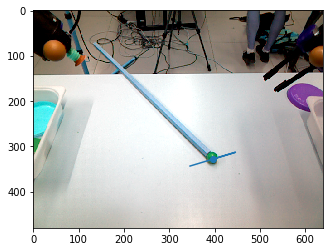

In [154]:
planner.getGrasp("pj")

In [155]:
B.sendToReal(True)
planner.exectuteGrasp()

pj


In [149]:
close_suction(False)

In [98]:
B.moveHard(q_home)

In [ ]:
q_copy = C.getJointState()



In [ ]:
x = grasp["x"]; y=grasp["y"]
data = np.array([x, y])
plt.scatter(x,y)
axis=np.array([np.cos(grasp["angle"]), np.cos(grasp["angle"])])
width_px = 10
g1= data - (width_px/2) * axis
g2= data + (width_px/2) * axis
g1p = g1 - 2* 5
g2p = g2 + 2* 5
plt.plot([[g1[0], g2[0]], [g1[1], g2[1]]],linewidth=10)
# direction of jaw line
jaw_dir = 5 * np.array([axis[1], -axis[0]])

# length of arrow
alpha = 2*(5 - 2)

# plot first jaw
g1_line = np.c_[g1p, g1 - 2*2*axis].T
plt.arrow(g1p[0], g1p[1], alpha*axis[0], alpha*axis[1])
jaw_line1 = np.c_[g1 + jaw_dir, g1 - jaw_dir].T

plt.plot(jaw_line1[:,0], jaw_line1[:,1]) 

# plot second jaw
g2_line = np.c_[g2p, g2 + 10*axis].T
plt.arrow(g2p[0], g2p[1], -alpha*axis[0], -alpha*axis[1])
jaw_line2 = np.c_[g2 + jaw_dir, g2 - jaw_dir].T
plt.plot(jaw_line2[:,0], jaw_line2[:,1])
plt.imshow(img)

In [ ]:
close_suction(True)

In [ ]:
close_pj(True)

In [ ]:
close = True 
B.sync(C)
q = C.getJointState()
print(q)
if close:
    q[-2] = 0.04
    print(q)
else:
    q[-2] = 0
B.moveHard(q)

In [ ]:
q_bin_pj = np.array([-0.0318301,  -0.23086411,  0.36777189, -0.32328645, -0.65769426,  0.9019807,
 -1.29736425,  1.0296846,   1.73800023, -0.95643702,  0.2711311,   1.20264094,
  1.01779625, -0.25080586, -0.49777677,  0.,          0.        ])